# IMPORTING LIBRARIES:

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import random
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# READING THE DATASET:

### Setting the file paths for a training dataset and a testing dataset. It then creates two empty lists, "train_paths" and "train_labels", and iterates through the folders within the training dataset directory to append the file paths and their corresponding labels to the appropriate lists. Then it shuffles the order of the file paths and labels.

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

### Creating a pie chart that represents the distribution of labels in a dataset called "train_labels." The chart shows the percentage of each label, "pituitary," "notumor," "meningioma," and "glioma," in the dataset. The colors of the chart are defined as specific RGB values, and the chart is labeled accordingly. The chart also has an "explode" feature which separates each slice of the pie chart by a small margin.





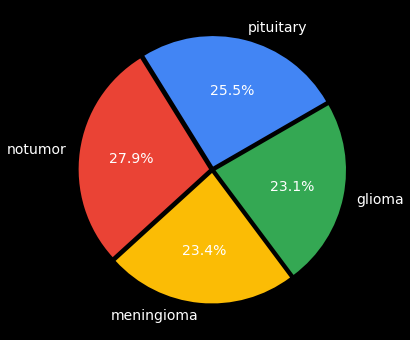

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# AS WE CAN SEE THAT THE DATASET IS REASONABLY BALANCED.

### Creating two empty lists, "test_paths" and "test_labels", and iterates through the folders within the testing dataset directory to append the file paths and their corresponding labels to the appropriate lists. It also shuffles the order of the file paths and labels.

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

### Creating a pie chart that represents the distribution of train and test datasets. The chart shows the percentage of each label, "train" and "test" in the dataset. The colors of the chart are defined as specific RGB values, and the chart is labeled accordingly. The chart also has an "explode" feature which separates each slice of the pie chart by a small margin.





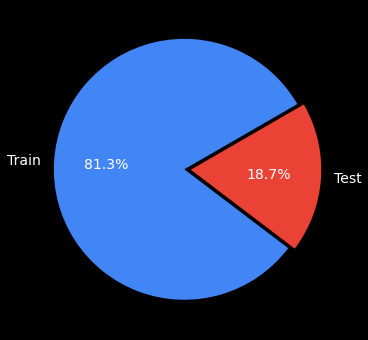

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# DATA AUGMENTATION:

### Defining a function called "augment_image" that takes in an image as an input. The function uses the Python Imaging Library (PIL) to convert the image to a PIL image object. Then it applies random brightness and contrast enhancements to the image using the ImageEnhance module, which adjusts the brightness and contrast of the image by a random value between 0.8 and 1.2. Finally, the function normalizes the image by dividing it by 255 and returns the augmented image.

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

Defining a function called "open_images" that takes in a list of paths to images and returns the images as arrays after augmenting them. The function first uses the keras function "load_img" to load the images and resize them to the specified size (128x128 pixels). Then it applies the augment_image function to each image. The function then returns the augmented images as an array.

The code then calls the open_images function on a subset of the train_paths (train_paths[50:59]) and assigns the result to the variable "images". It also assigns the corresponding subset of train_labels to the variable "labels".

Then it creates a figure of size (12,6) and plots 8 images with their corresponding label, with a title of their label. it also turns off the axis and show the images on the figure. The function also updates the font size of the title of the images and shows the figure.

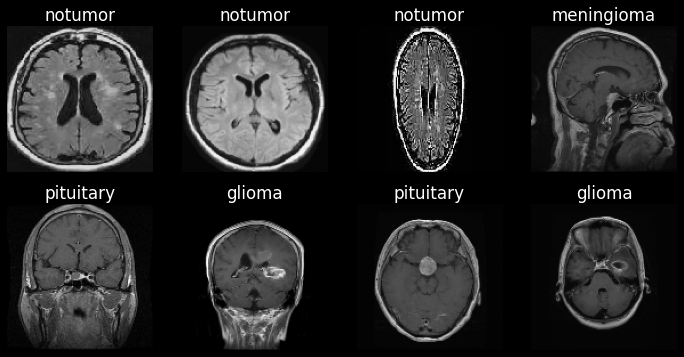

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# DATA GENERATOR HELPS AUGMENT IMAGES, NORMALIZES THEM.

The `datagen` function generates data for training and testing. It takes three arguments: `paths`, `labels` and `batch_size` (default 12) and `epochs` (default 1).

It uses the `open_images` function to open and augment the images and the encode_label function to convert the labels to numerical values. The function then yields the batch of images and labels, allowing the model to train on them. The `for _ in range(epochs)` loop allows you to specify the number of times the entire dataset should be passed through the model. And `for x in range(0, len(paths), batch_size)` is used for iterating over the dataset in batches of the specified batch_size.

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58900480/58889256 [==============================] - 0s 0us/step


The `model.summary()` method in Keras prints a summary of the architecture of the model. This summary includes the layers in the model, their output shapes, the number of parameters in each layer, and the total number of parameters in the model. This can be useful for understanding the overall structure of the model and for identifying potential issues such as overfitting. In the code provided, `model.summary()` shows the architecture of the image classification model created using a pre-trained VGG16 model and some additional layers.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 15,763,908
Trainable params: 8,128,644
Non-trainable params: 7,635,264
_____________________________________

`model.compile` is used to configure the learning process before training the model. The optimizer is the algorithm used to update the weights of the model based on the gradients of the loss function. In this case, the `Adam` optimizer is used with a learning rate of 0.0001. The learning rate controls the step size at which the optimizer makes updates to the weights. A smaller learning rate will make the optimization converge slower but potentially with better results.

The loss function is used to measure how well the model is doing on the training data. The loss is a scalar value that represents the degree of error in the model's predictions. The `sparse_categorical_crossentropy` loss is used in this case, which is a measure of the dissimilarity between the predicted and actual labels.

The metrics parameter is used to specify the metrics that will be evaluated during training and testing. The `sparse_categorical_accuracy` metric is used in this case, which calculates the mean accuracy rate across all predictions for multiclass classification problems.





In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# TRAINING THE MODEL:

The fit method takes in the following arguments:

* datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs): This argument specifies the training data generator to use. The datagen function generates batches of images and labels for training. It takes in the list of paths to the training images, the corresponding labels, the batch size and number of epochs. The datagen function will be called multiple times (once per epoch) and will yield a new batch of images and labels each time it is called.


* epochs=epochs: This argument specifies the number of times the model should go through the entire training dataset.

* steps_per_epoch=steps: This argument specifies the number of batches to use per epoch.


The batch_size variable is set to 20, which means that the model will be trained on 20 images at a time. The steps variable is set to the total number of images divided by the batch size. The epochs variable is set to 4, so the model will go through the entire training dataset 4 times. The training is done by repeatedly calling the datagen function to get new batches of images and labels, and then training the model on those batches. The history variable will store the training history, which can be used to plot the training progress, or extract training statistics.





In [12]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 [==============================] - 521s 2s/step - loss: 0.4570 - sparse_categorical_accuracy: 0.8274
Epoch 2/5
285/285 [==============================] - 518s 2s/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9209
Epoch 3/5
285/285 [==============================] - 519s 2s/step - loss: 0.1535 - sparse_categorical_accuracy: 0.9454
Epoch 4/5
285/285 [==============================] - 518s 2s/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9622
Epoch 5/5
285/285 [==============================] - 512s 2s/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9715


Creating a plot of the training history of the model, including the accuracy and loss over the number of epochs. The x-axis represents the number of epochs and the y-axis shows the value of accuracy and loss. The plot is created using matplotlib library, it has two lines one for accuracy and one for loss. The plot helps in visualizing how the model is learning and how well it is performing during the training process. It is useful for identifying overfitting, underfitting, and to decide when to stop training.

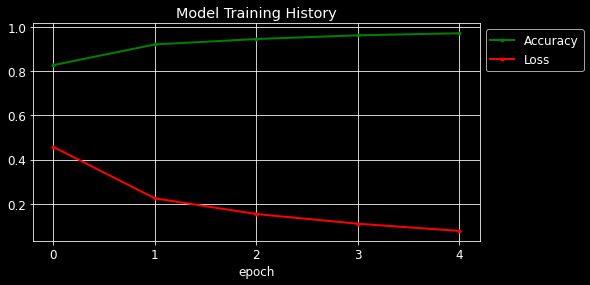

In [13]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# EVALUATING MODEL WITH TEST SAMPLES:

Trained model to make predictions on the test set, which consists of the test_paths and test_labels. It uses the datagen() function to generate batches of images and labels, and for each batch it uses the model.predict() method to make predictions on the images. The predicted labels are in encoded form and using decode_label() function they are decoded and stored in y_pred. The actual labels are stored in y_true. The tqdm library is used to display a progress bar for the loop.





In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

41it [01:50,  2.69s/it]                        


Generating a classification report which evaluates the performance of the model on the test dataset. The report contains various metrics such as precision, recall, f1-score and support for each class in the dataset. It also calculates a weighted average of these metrics across all classes. This report helps in understanding the overall performance of the model and identifying any specific classes where the model is performing well or poorly.

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.91      0.93      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# Let's Check about the working of the model:

In [16]:
def names(number):
    if number==0:
        return 'No, Its not a tumor'
    else:
        return 'Its a Tumor'

In [17]:
from PIL import Image

100.0% Conclusion: Its a Tumor


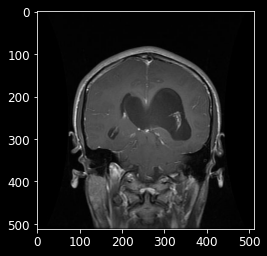

In [18]:
from matplotlib.pyplot import imshow
img = Image.open(r"/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0002.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


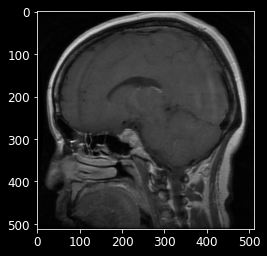

In [19]:
from matplotlib.pyplot import imshow
img = Image.open(r"/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0004.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


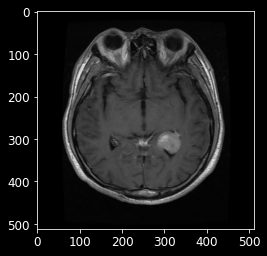

In [20]:
from matplotlib.pyplot import imshow
img = Image.open(r"/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0001.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: No, Its not a tumor


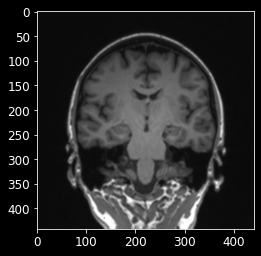

In [21]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'   
from matplotlib.pyplot import imshow
img = Image.open(r"/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-noTr_0004.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))